# Are JPY and SGD Cointegrated?

### Cointegration involves two steps: 
##### 1. Regressing one time series on the other to get the cointegration vector
##### 2. Perform an ADF test on the residuals of the regression.

In [1]:
# import the libraries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings('ignore')

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# import the data
df_jpy = pd.read_csv('Data/DEXJPUS_19710104_20180504.csv', header=0, index_col='DATE')
df_sgd = pd.read_csv('Data/DEXSIUS_19810102_20180504.csv', header=0, index_col='DATE')

In [3]:
# prepare the data, consider data since 2000 and forwward fill any na values
df_jpy.index = pd.to_datetime(df_jpy.index)
df_jpy = df_jpy.loc['2000-01-01':]
df_jpy.DEXJPUS = pd.to_numeric(df_jpy.DEXJPUS, errors='coerce')
df_jpy = df_jpy.fillna(method='ffill')

df_sgd.index = pd.to_datetime(df_sgd.index)
df_sgd = df_sgd.loc['2000-01-01':]
df_sgd.DEXSIUS = pd.to_numeric(df_sgd.DEXSIUS, errors='coerce')
df_sgd = df_sgd.fillna(method='ffill')

df = df_jpy.join(df_sgd, how='outer')
df.head()

,DEXJPUS,DEXSIUS
DATE,,
2000-01-03,101.70,1.6563
2000-01-04,103.09,1.6535
2000-01-05,103.77,1.6560
2000-01-06,105.19,1.6655
2000-01-07,105.17,1.6625


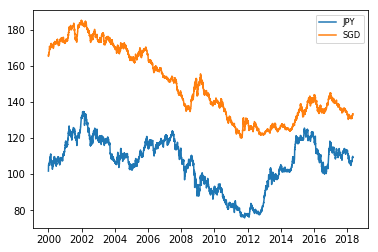

In [4]:
# plot JPY time series
# scale SGD to that of JPY by multiplying by 100
_ = plt.plot(df_jpy, label='JPY')
_ = plt.plot(df_sgd*100, label='SGD') 
_ = plt.legend(loc='best', fontsize='small')
plt.show()
plt.clf()
plt.cla()
plt.close()

### Cointegration Vector
We need to find a cointegration vector which links between the 2 series. We link both series in the form of y = mx + c where m is the cointegration vector.

In [5]:
df_sgd = sm.add_constant(df_sgd)

In [6]:
df_sgd.head()

,const,DEXSIUS
DATE,,
2000-01-03,1.0,1.6563
2000-01-04,1.0,1.6535
2000-01-05,1.0,1.6560
2000-01-06,1.0,1.6655
2000-01-07,1.0,1.6625


In [7]:
result= sm.OLS(df_jpy, df_sgd).fit()
print(result.params)
m = result.params[1]
print('The cointegration vector is: {0}'.format(m))

const      38.333434
DEXSIUS    45.582799
dtype: float64
The cointegration vector is: 45.582799173759376


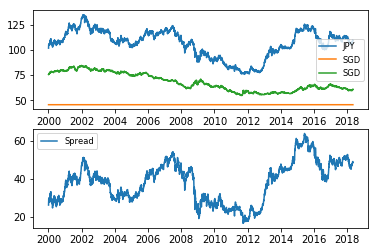

In [8]:
# plot the JPY and SGD timeseries again, 
#as well as the proposed cointegration plot

_ = plt.subplot(2,1,1)
_ = plt.plot(df_jpy, label='JPY')
_ = plt.plot(df_sgd*m, label='SGD')
_ = plt.legend(loc='best', fontsize='small')

_ = plt.subplot(2,1,2)
_ = plt.plot(df_jpy['DEXJPUS']-m*df_sgd['DEXSIUS'], label='Spread')
_ = plt.legend(loc='best', fontsize='small')

Visually inspecting JPY and SGD, we can see that they are quite clearly a random walk. Visually inspecting JPY-m*SGD also suggest that they this series is also a random walk, or maybe not.

Lets do a augmented dicky fuller test on all these series to test for stationarity and random walks.

### Augmented Dicky Fuller Tests to test for Random Walks
1. ADF Test on JPY and SGD individual to test for random walks
2. ADF Test on JPY-m*SGD to test for random walks. If this is not a random walk, then we can say that both JPY and SGD are cointegrated with cointegration vector m.

In [9]:
result = adfuller(df_jpy['DEXJPUS'])
print('The p-value for the ADF test on JPY is: {0}'.format(result[1]))

The p-value for the ADF test on JPY is: 0.4348157690666751


In [10]:
result = adfuller(df_sgd['DEXSIUS'])
print('The p-value for the ADF test on SGD is: {0}'.format(result[1]))

The p-value for the ADF test on SGD is: 0.7659899645851036


In [11]:
result = adfuller(df_jpy['DEXJPUS'] - df['DEXSIUS']*m)
print('The p-value for the ADF test on JPY - SGD*m is: {0}'.format(result[1]))

The p-value for the ADF test on JPY - SGD*m is: 0.2808274429253699


### Summary
The ADF test does not suggest that both JPY and SGD are cointegrated.
In all 3 ADF tests above, the null hypothesis cannot be rejected that there is a unit root in the series, suggesting non-stationarity.